# Import Library

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import NeighborLoader
from torch_geometric.nn import MessagePassing, BatchNorm
from torch_geometric.utils import to_networkx, subgraph, k_hop_subgraph
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')



In [2]:
# Set random seeds
torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Load Cora Dataset

In [3]:
dataset = Planetoid(root="data/Cora", name="Cora")
data = dataset[0]

In [4]:
#Jumlah Node
data.num_nodes

2708

In [5]:
#jumlah edge
data.num_edges

10556

In [6]:
#dimensi fitur
data.num_features

1433

In [7]:
#jumlah keasl
dataset.num_classes

7

In [8]:
#nama kelas
data.y.unique()

tensor([0, 1, 2, 3, 4, 5, 6])

In [9]:
#nodes belong to classes
data.y.bincount()

tensor([351, 217, 418, 818, 426, 298, 180])

In [10]:
class_counts = data.y.bincount()
for class_idx in range(len(class_counts)):
    print(f"Kelas {class_idx}: {class_counts[class_idx].item()} nodes")

Kelas 0: 351 nodes
Kelas 1: 217 nodes
Kelas 2: 418 nodes
Kelas 3: 818 nodes
Kelas 4: 426 nodes
Kelas 5: 298 nodes
Kelas 6: 180 nodes


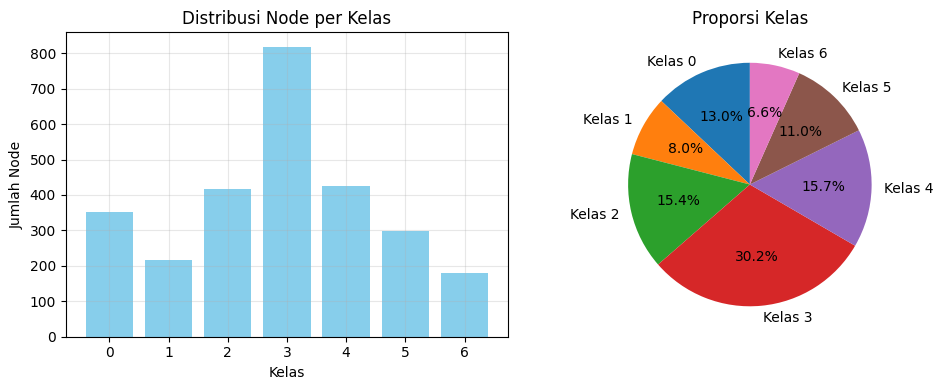

In [11]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.bar(range(len(class_counts)), class_counts.numpy(), color='skyblue')
plt.title('Distribusi Node per Kelas')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Node')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.pie(class_counts.numpy(), labels=[f'Kelas {i}' for i in range(len(class_counts))], 
        autopct='%1.1f%%', startangle=90)
plt.title('Proporsi Kelas')

plt.tight_layout()
plt.show()

In [12]:
#train nodes
data.train_mask.sum().item()

140

In [13]:
print(f"\nTrain ratio: {data.train_mask.sum().item()/data.num_nodes:.2%}")


Train ratio: 5.17%


In [14]:
#validation nodes
data.val_mask.sum().item()

500

In [15]:
print(f"Validation ratio: {data.val_mask.sum().item()/data.num_nodes:.2%}")

Validation ratio: 18.46%


In [16]:
#test nodes
data.test_mask.sum().item()

1000

In [17]:
print(f"Test ratio: {data.test_mask.sum().item()/data.num_nodes:.2%}")

Test ratio: 36.93%


In [18]:
data.edge_index.shape

torch.Size([2, 10556])

In [19]:
data.edge_index[:, :5]

tensor([[ 633, 1862, 2582,    2,  652],
        [   0,    0,    0,    1,    1]])

In [20]:
data.x[0, :10]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# PRA-PROSES (Message Passing Layer)

$h_u^{(k)} = \sum W_{\text{msg}} \cdot h_u^{(k-1)} + W_{\text{self}} \cdot h_v^{(k-1)}$

 di mana,
 1. **k** adalah urutan lapisan GNN.
 2. **Wmsg** adalah bobot yang diakses bersama dengan neighborhood nodes.
 3. **Wself** adalah bobot milik node asal (v).

In [21]:
class CustomMessagePassing(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='add')
        self.W_msg = nn.Linear(in_channels, out_channels)  # For neighbors
        self.W_self = nn.Linear(in_channels, out_channels) # For self
        
    def forward(self, x, edge_index):
        return self.propagate(edge_index, x=x)
    
    def message(self, x_j):
        return self.W_msg(x_j)  # W_msg * h_u
    
    def update(self, aggr_out, x):
        return aggr_out + self.W_self(x)  # Σ + W_self * h_v

In [22]:
# TEST MESSAGE PASSING

test_mp = CustomMessagePassing(in_channels=16, out_channels=32)
test_mp

CustomMessagePassing()

In [23]:
test_mp.W_msg.weight.shape

torch.Size([32, 16])

In [24]:
test_mp.W_self.weight.shape

torch.Size([32, 16])

# Intra-layer GNN Block

$$
\mathbf{h}_v^{(k)} =
\text{ACT}\!\left(
    \text{Dropout}\!\left(
        \text{BatchNorm}\!\left(
            \mathbf{W}^{(k-1)}\,\mathbf{h}_v^{(k-1)} + \mathbf{b}^{(k-1)}
        \right)
    \right)
\right)
+ \mathbf{h}_v^{(k-1)}
$$


di mana:

1. **ACT** adalah fungsi aktivasi yang Anda pilih.
2. **BatchNorm** adalah `1D-Batch Normalization`.


## DEFINE SINGLE GNN LAYER 

In [25]:
class GNNLayer(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.5):
        super().__init__()
        # Linear transformation - receives output from message passing (out_channels)
        self.linear = nn.Linear(out_channels, out_channels)
        
        # Message passing layer (persistent, not created each forward)
        self.message_passing = CustomMessagePassing(in_channels, out_channels)
        
        self.batch_norm = BatchNorm(out_channels)
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.ReLU()
        
        # Residual connection
        if in_channels != out_channels:
            self.residual = nn.Linear(in_channels, out_channels)
        else:
            self.residual = nn.Identity()
    
    def forward(self, x, edge_index):
        x_input = x
        
        # Message passing (using persistent module - already on correct device)
        x_mp = self.message_passing(x, edge_index)
        
        # Linear → BatchNorm → Dropout → Activation
        x_linear = self.linear(x_mp)
        x_bn = self.batch_norm(x_linear)
        x_drop = self.dropout(x_bn)
        x_act = self.activation(x_drop)
        
        # Add residual: x_act + x_input
        x_residual = self.residual(x_input)
        return x_act + x_residual

## Test GNN Layer

In [26]:
test_layer = GNNLayer(in_channels=16, out_channels=32)
test_layer

GNNLayer(
  (linear): Linear(in_features=32, out_features=32, bias=True)
  (message_passing): CustomMessagePassing()
  (batch_norm): BatchNorm(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (activation): ReLU()
  (residual): Linear(in_features=16, out_features=32, bias=True)
)

In [27]:
test_layer.batch_norm

BatchNorm(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [28]:
test_layer.dropout.p

0.5

In [29]:
test_layer.activation

ReLU()

# Full Model with k>1 Layers

## Build Model

In [30]:
class GNNModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        
        # Feature projection (reduce dimensions)
        self.input_proj = nn.Linear(in_channels, hidden_channels)
        
        # k > 1: Multiple layers (using 3 layers)
        self.layer1 = GNNLayer(hidden_channels, hidden_channels)
        self.layer2 = GNNLayer(hidden_channels, hidden_channels)
        self.layer3 = GNNLayer(hidden_channels, out_channels, dropout=0.3)
        
        # Final classifier
        self.classifier = nn.Linear(out_channels, out_channels)
    
    def forward(self, x, edge_index):
        # Project features
        x = F.relu(self.input_proj(x))
        
        # Multiple GNN layers (k > 1)
        x = self.layer1(x, edge_index)
        x = self.layer2(x, edge_index)
        x = self.layer3(x, edge_index)
        
        # Classify
        x = self.classifier(x)
        return F.log_softmax(x, dim=-1)

## Initialize Model

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [32]:
model = GNNModel(
    in_channels=data.num_features,
    hidden_channels=512,
    out_channels=dataset.num_classes
).to(device)

print(f"Model created on {device}")

Model created on cuda


## CHECK MODEL PARAMETERS

In [33]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

In [34]:
print(f"Total parameters: {total_params:,}")

Total parameters: 2,323,091


In [35]:
print(f"Trainable parameters: {trainable_params:,}")

Trainable parameters: 2,323,091


In [36]:
print("\nParameter shapes:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"  {name:30} {tuple(param.shape)}")


Parameter shapes:
  input_proj.weight              (512, 1433)
  input_proj.bias                (512,)
  layer1.linear.weight           (512, 512)
  layer1.linear.bias             (512,)
  layer1.message_passing.W_msg.weight (512, 512)
  layer1.message_passing.W_msg.bias (512,)
  layer1.message_passing.W_self.weight (512, 512)
  layer1.message_passing.W_self.bias (512,)
  layer1.batch_norm.module.weight (512,)
  layer1.batch_norm.module.bias  (512,)
  layer2.linear.weight           (512, 512)
  layer2.linear.bias             (512,)
  layer2.message_passing.W_msg.weight (512, 512)
  layer2.message_passing.W_msg.bias (512,)
  layer2.message_passing.W_self.weight (512, 512)
  layer2.message_passing.W_self.bias (512,)
  layer2.batch_norm.module.weight (512,)
  layer2.batch_norm.module.bias  (512,)
  layer3.linear.weight           (7, 7)
  layer3.linear.bias             (7,)
  layer3.message_passing.W_msg.weight (7, 512)
  layer3.message_passing.W_msg.bias (7,)
  layer3.message_passing.W_s

## SET UP OPTIMIZER

In [37]:
optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=10
)

In [38]:
print(f"Learning rate: {optimizer.param_groups[0]['lr']}")

Learning rate: 0.005


In [39]:
print(f"Weight decay: {optimizer.param_groups[0]['weight_decay']}")

Weight decay: 0.0005


In [40]:
# move data to device
data = data.to(device)
device
data.x.device
data.edge_index.device

device(type='cuda', index=0)

# Show Model Structure

In [41]:
model

GNNModel(
  (input_proj): Linear(in_features=1433, out_features=512, bias=True)
  (layer1): GNNLayer(
    (linear): Linear(in_features=512, out_features=512, bias=True)
    (message_passing): CustomMessagePassing()
    (batch_norm): BatchNorm(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (activation): ReLU()
    (residual): Identity()
  )
  (layer2): GNNLayer(
    (linear): Linear(in_features=512, out_features=512, bias=True)
    (message_passing): CustomMessagePassing()
    (batch_norm): BatchNorm(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (activation): ReLU()
    (residual): Identity()
  )
  (layer3): GNNLayer(
    (linear): Linear(in_features=7, out_features=7, bias=True)
    (message_passing): CustomMessagePassing()
    (batch_norm): BatchNorm(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout): Dropout(p=0.3

In [42]:
for name, module in model.named_children():
    print(f"\n{name}: {module}")


input_proj: Linear(in_features=1433, out_features=512, bias=True)

layer1: GNNLayer(
  (linear): Linear(in_features=512, out_features=512, bias=True)
  (message_passing): CustomMessagePassing()
  (batch_norm): BatchNorm(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (activation): ReLU()
  (residual): Identity()
)

layer2: GNNLayer(
  (linear): Linear(in_features=512, out_features=512, bias=True)
  (message_passing): CustomMessagePassing()
  (batch_norm): BatchNorm(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (activation): ReLU()
  (residual): Identity()
)

layer3: GNNLayer(
  (linear): Linear(in_features=7, out_features=7, bias=True)
  (message_passing): CustomMessagePassing()
  (batch_norm): BatchNorm(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (activation): ReLU()
  (residual): Line

# Training

In [43]:
print(f"Optimizer: {optimizer}")
print(f"Scheduler: {scheduler}")
print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
print(f"Epochs: 150")
print(f"Early stopping patience: 20")
print(f"Device: {device}")

Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.005
    maximize: False
    weight_decay: 0.0005
)
Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x00000184FF36F850>
Learning rate: 0.005
Epochs: 150
Early stopping patience: 20
Device: cuda


## RAINING LOOP WITH VALIDATION LOSS

In [44]:
# def get_validation_loss(model, data):
#     model.eval()
#     with torch.no_grad():
#         out = model(data.x, data.edge_index)
#         loss = F.nll_loss(out[data.val_mask], data.y[data.val_mask])
#     return loss.item()

# # Then track both losses:
# val_losses = []
# for epoch in range(epochs):
#     train_loss = train_one_epoch(...)
#     val_loss = get_validation_loss(model, data)
#     val_losses.append(val_loss)  # We're missing this!

## SEtup

In [45]:
train_losses = []
val_accuracies = []
test_accuracies = []

### DEFINE TRAINING STEP FUNCTION

In [46]:
def train_one_epoch(model, data, optimizer):
    model.train()
    optimizer.zero_grad()
    
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    
    return loss.item()

### DEFINE EVALUATION FUNCTION

In [47]:
def evaluate(model, data, mask):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out[mask].argmax(dim=1)
        correct = (pred == data.y[mask]).sum().item()
        total = mask.sum().item()
        accuracy = correct / total
    return accuracy

## RUN EPOCH

In [49]:
best_val_acc = 0
patience_counter = 0
patience = 20


for epoch in range(150):
    # Train
    loss = train_one_epoch(model, data, optimizer)
    train_losses.append(loss)
    
    # Evaluate
    val_acc = evaluate(model, data, data.val_mask)
    test_acc = evaluate(model, data, data.test_mask)
    val_accuracies.append(val_acc)
    test_accuracies.append(test_acc)
    
    # Update scheduler
    scheduler.step(loss)
    
    # Check best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
    
    # Print progress
    if epoch % 10 == 0:
        print(f'Epoch {epoch:3d}: Loss={loss:.4f}, Val={val_acc:.4f}, Test={test_acc:.4f}')
    
    # Early stopping
    if patience_counter >= patience:
        print(f'Early stopping at epoch {epoch}')
        break

Epoch   0: Loss=0.0002, Val=0.5460, Test=0.5330
Epoch  10: Loss=0.0009, Val=0.4920, Test=0.4760
Epoch  20: Loss=0.0007, Val=0.5200, Test=0.5050
Early stopping at epoch 20


### Load best model

In [50]:
model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

## PLOT

### Training loss

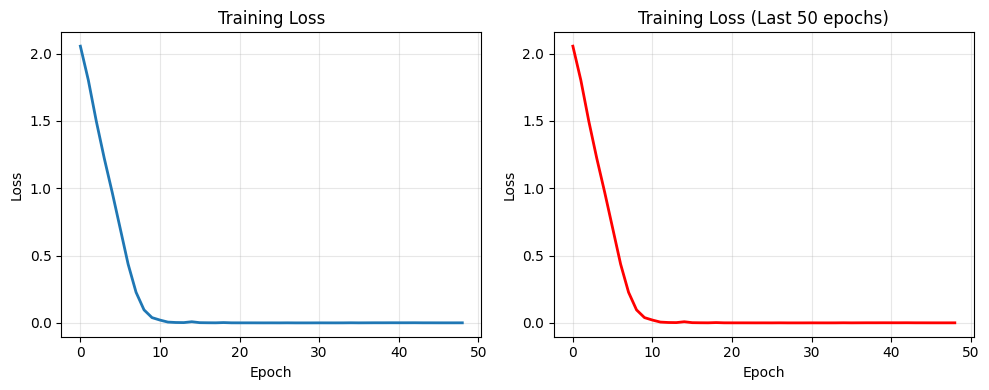

In [51]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, linewidth=2)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
# Plot last 50 losses to see detail
plt.plot(train_losses[-50:], linewidth=2, color='red')
plt.title('Training Loss (Last 50 epochs)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### ACCURACIES

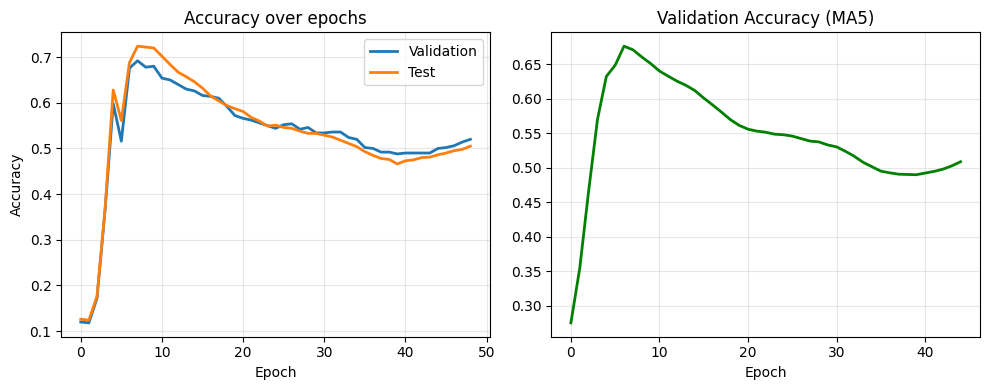

In [52]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(val_accuracies, label='Validation', linewidth=2)
plt.plot(test_accuracies, label='Test', linewidth=2)
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
# Moving average
window = 5
val_ma = np.convolve(val_accuracies, np.ones(window)/window, mode='valid')
plt.plot(val_ma, linewidth=2, color='green')
plt.title(f'Validation Accuracy (MA{window})')
plt.xlabel('Epoch')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()